In [12]:
import yfinance as yf

msft = yf.Ticker("META")
msft_hist = msft.history(period="max")

In [39]:
msft_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-05-18 00:00:00-04:00,42.049999,45.000000,38.000000,38.230000,573576400,0,0
2012-05-21 00:00:00-04:00,36.529999,36.660000,33.000000,34.029999,168192700,0,0
2012-05-22 00:00:00-04:00,32.610001,33.590000,30.940001,31.000000,101786600,0,0
2012-05-23 00:00:00-04:00,31.370001,32.500000,31.360001,32.000000,73600000,0,0
2012-05-24 00:00:00-04:00,32.950001,33.209999,31.770000,33.029999,50237200,0,0


<AxesSubplot: xlabel='Date'>

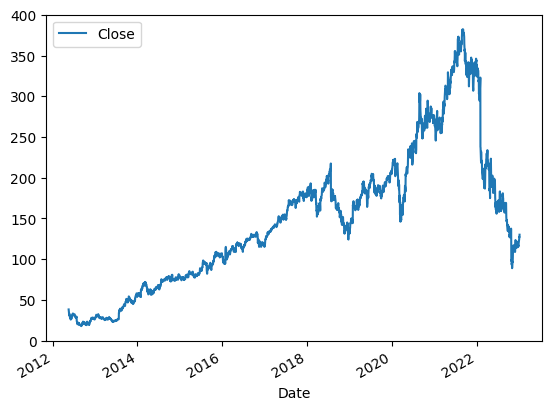

In [14]:
msft_hist.plot.line(y="Close", use_index=True)

In [15]:
data = msft_hist[["Close"]]
data = data.rename(columns= {'Close':'Actual_Close'})
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [16]:
data.head()

,Actual_Close,Target
Date,,
2012-05-18 00:00:00-04:00,38.230000,NaN
2012-05-21 00:00:00-04:00,34.029999,0.0
2012-05-22 00:00:00-04:00,31.000000,0.0
2012-05-23 00:00:00-04:00,32.000000,1.0
2012-05-24 00:00:00-04:00,33.029999,1.0


In [17]:
msft_prev = msft_hist.copy()

In [18]:
msft_prev = msft_prev.shift(1)

In [20]:
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-05-18 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-21 00:00:00-04:00,42.049999,45.00,38.000000,38.230000,573576400.0,0.0,0.0
2012-05-22 00:00:00-04:00,36.529999,36.66,33.000000,34.029999,168192700.0,0.0,0.0
2012-05-23 00:00:00-04:00,32.610001,33.59,30.940001,31.000000,101786600.0,0.0,0.0
2012-05-24 00:00:00-04:00,31.370001,32.50,31.360001,32.000000,73600000.0,0.0,0.0


In [21]:
predictors = ["Close", "High", "Low", "Open", "Volume"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [22]:
data.head()

,Actual_Close,Target,Close,High,Low,Open,Volume
Date,,,,,,,
2012-05-21 00:00:00-04:00,34.029999,0.0,38.230000,45.000000,38.000000,42.049999,573576400.0
2012-05-22 00:00:00-04:00,31.000000,0.0,34.029999,36.660000,33.000000,36.529999,168192700.0
2012-05-23 00:00:00-04:00,32.000000,1.0,31.000000,33.590000,30.940001,32.610001,101786600.0
2012-05-24 00:00:00-04:00,33.029999,1.0,32.000000,32.500000,31.360001,31.370001,73600000.0
2012-05-25 00:00:00-04:00,31.910000,0.0,33.029999,33.209999,31.770000,32.950001,50237200.0


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# model = GradientBoostingClassifier(n_estimators=100, min_samples_split=200, random_state=1)
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)
train = data.iloc[:-100]
test = data.iloc[-100:]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [24]:
from sklearn.metrics import precision_score
import pandas as pd
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [25]:
score = precision_score(test["Target"], preds)
combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)

In [26]:
score

0.4868421052631579

<AxesSubplot: xlabel='Date'>

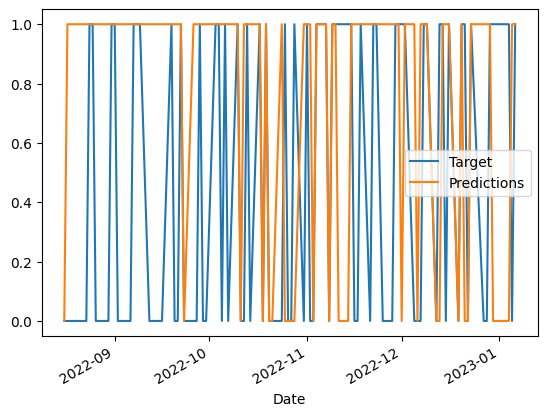

In [27]:
combined.plot()

In [28]:
import numpy as np
start =1000
step = 750
# i = 1000


def backtest(data, model, predictors, start=1000, step=750):
    
    for i in range(start, data.shape[0], step):
        predictions = []
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()


        model.fit(train[predictors], train["Target"])

        preds = model.predict_proba(test[predictors])[:,1]

        preds = pd.Series(preds, index = test.index)
        preds[preds > 0.6] = 1
        preds[preds <= 0.6] = 0

        combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis = 1)

        predictions.append(combined)

    predictions = pd.concat(predictions)
    return predictions
#predictions["Predictions"].value_counts()

In [29]:
predictions = backtest(data, model, predictors)

predictions["Predictions"].value_counts()

0.0    169
1.0      7
Name: Predictions, dtype: int64

In [30]:
# precision = _prf_divide(tp_sum, pred_sum, 'precision', 'predicted', average, warn_for, zero_division)
score = precision_score(predictions["Target"], predictions["Predictions"])

In [31]:
score

0.42857142857142855

## Improving Accuracy of the model

In [32]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()

weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [33]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "weekly_trend", "open_close_ratio", "high_close_ratio", "low_close_ratio"]





In [34]:
predictions = backtest(data.iloc[365:], model, full_predictors)

In [37]:
precision_score(predictions["Target"],predictions["Predictions"])

0.4609375

In [36]:
predictions["Predictions"].value_counts()

0.0    433
1.0    128
Name: Predictions, dtype: int64